<a href="https://colab.research.google.com/github/grniemeyer/IANNwTF_hw2/blob/main/PlayingWithMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


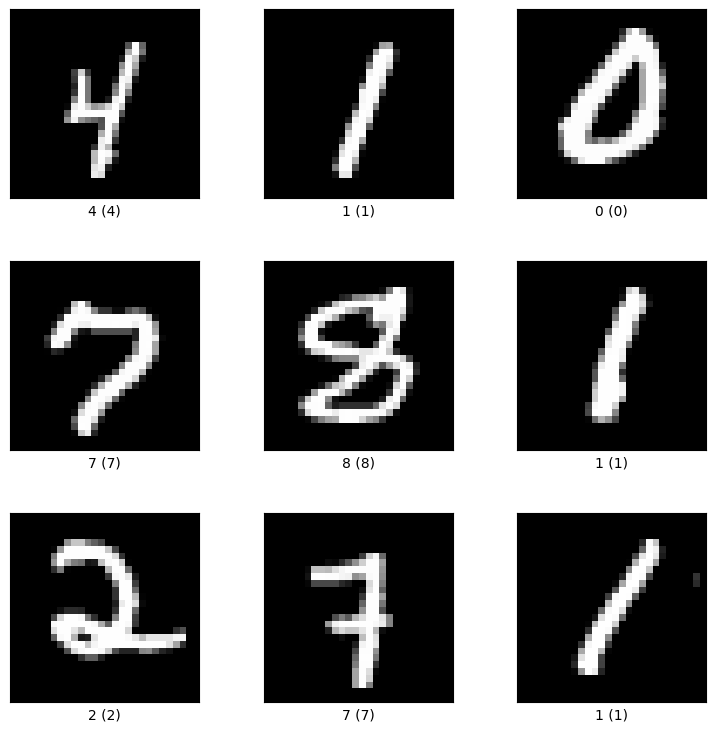

tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], shape=(4, 784), dtype=float32) tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(4, 10), dtype=float32)


In [46]:
# Data prep

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# tensorflow = (data) pipeline, factory
# tensorflow tensor like array


(train_ds,test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], with_info=True)
# print(ds_info)
# tfds.show_examples(train_ds, ds_info)


# remember order for exam!!
ds = train_ds.map(lambda feature_dict: (feature_dict["image"], feature_dict["label"])) # ectract images and features
ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label)) # flatten images, pass on labels
ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32) / 128.0) -1, label)) # normalize images and pass on
ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10))) # one hottify
ds = ds.shuffle(1024).batch(4) # create small buffer(9 pieces of choc bzw. 1024) in between for shuffling then batch; tf's batch operation takes care of the remainder shape
trains_ds = ds.prefetch(4) # parralelisation: 2nd buffer that has always shuffled (prefetched) batches availabe. Shuffling & prefetching takes lot of memory


for x, y in ds.take(1):
  print(x, y)


# • How many training/test images are there?
# - 'test' 10,000, train' 60,000
# • What’s the image shape?
# - (28, 28, 1)
# • What range are pixel values in?
# - In grayscale images, a pixel value of 0 represents black, and 255 represents white

In [55]:
# 2.3 Building a DNN with TF
from tensorflow.keras.layers import Dense

class MyDeepNN():
  def __init__(self):
    super(MyDeepNN, self).__init__()
    self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
    self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

  @tf.function # decorator -> adds special functionalities to function below
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    y = self.out(x)
    return y




In [56]:
# 2.4 Training the Network


# define hyperparameters
nr_epochs = 10
learning_rate = 0.1

# initialize stuff
mymodel = MyDeepNN()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
opti = tf.keras.optimizers.SGD(learning_rate)

# lists (for viualization later)
train_losses = []
test_losses = []
test_accuracies = []

# test before sending through NN, for comparison afterwards
#test_loss, test_accuracy = test(mymodel, train_ds, cross_entropy_loss)
#test_losses_append(test_loss)
#test_accuracies.append(test_accuracy)

# test with train_ds before training NN
#train_loss,_ = test(mymodel, train_ds, cross_entropy_loss)
#train_losses.append(train_loss)


# tests on 1 input-target pair
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables) # trainable_variables = weights?
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss


def test(model, test_ds, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (image, target) in test_ds:
    prediction = model(image)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.argmax(target, axis=1) == np.armay(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))# double averaging??

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy



for epoch in range(nr_epochs):
#  print(f"epoch: {str(epoch)} with accuracy {test_accuracies[-1]}") # starting with last element in test_accuracies

  # training
  epoch_losses = []
  for image, label in train_ds:
    train_loss = train_step(mymodel, image, label, cross_entropy_loss, opti)
    epoch_losses.append(train_loss)

  # track training loss
  train_losses.append(tf.reduce_mean(epoch_losses)) #take the mean

  # testing (track test loss and test accuracy)
  test_loss, test_accuracy = test(mymodel,test_ds, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


TypeError: ignored

In [34]:
# Model Creation via Subclassing from tf.keras.Model

#inherit from keras.Model
class MLP_Model(self, layer_size):
  def __init__(self, layer_size, output_size=10):
    super().__init__()
    self.layers = []
    #layer_size e.g.[256, 256]

    for layer_size in layer_sizes:
      new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
      self.layers.append(new_layer)
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax") # output layer ist deshalb specified seperately bc we need different activation function

  def call(self, x):
    for layer in self.layers:
      x = layer(x) # call layer on input
    y = self.output.layer(x)
    return y

ModuleNotFoundError: ignored

In [ ]:
# Training

EPOCHS = 10

model = MLP_Model(layer_sizes=[256, 256])
cce = tf.keras.CategoricalCrossEntropy()
optimizer = tf.keras.optimizers.legacy.SGD() # stochastic gradient as optimizer
ds = ds # does nothing, just as reminder from above

for epoch in range(EPOCHS):
  losses = []

  for x, target in ds:
    with tf.GradientTape() as tape: # context manager
      pred = model(x)
      loss = cce(target, pred)
    gradients = tape.gradient(loss, model.varibles) # calculate gradient outside of GradientTape, otherwis it calculates gradient of gradient (memory!!, rare exceptions)
    optimizer.appy_gradients(zip(gradients, model.variables))
    losses.append(loss.numpy())
  print(np.mean(losses))

### TF Session 20.11.23 - custom gradient

In [ ]:
# custom gradient
import tensorflow as tf
import numpy as np


sample_input = tf.random.uniform(shape = (4,2), dtype=np.float32)

# @ - indicates a decorater function

#tf.custom_gradient()


# writing own sigmoid

@tf.custom_gradient
def my_sigmoid(x):
  sigmoid_res = 1/1+tf.exp(-x)
  def grad(upstream):
    diag_of_jacobian = sigmoid_res*(1-sigmoid_res)
    downstream = upstream*diag_of_jacobian
  return sigmoid_res, grad

In [ ]:
# writing own ReLu

# hint: use with tf.where

def my_relu(x):
  relus = tf.where(x>0, x, tf.zeros_like(x))

  def grad(upstream):
    d_dx = tf.where(x>0, tf.ones_like(x), tf.zeros_like(x))
    downstream = upstream*d_dx
    return downstream
  return relus, grad

In [ ]:
# explain gradientTape

sample_input = tf.Variable(initial_value=sample_input)
with tf.GradientTape(persistent = True) as tape:
  my_relu_act = my_relu(sample_input)
#  tf_relu_act = tf.nn.relu(sample_input) # common tf relu for comparison (however not possible to compute together, too much memory asked, so not possible or tell to be "persistent", buuut can crash your memory) 1.0
#grads_tf_relu = tape.gradient(tf_relu_act, [sample_input]) # 2.0
grads_my_relu = tape.gradient(my_relu_act, [sample_input])
print(grads_my_relu)

TypeError: ignored

In [ ]:
res = []
sample_input = tf.Variable(initial_value=tf.random.uniform(shape=(4,3)))

@tf.function # saves time??, however only for tensorflow code, NO classical python code (print(), .append(), etc)
def some_tf_loop():
  for step in tf.range(10):
    inputs = sample_input[step,:,:]
  with tf.GradientTape(persistent = True) as tape:
    my_relu_act = my_relu(sample_input)
    tf_relu_act = tf.nn.relu(sample_input)
  grads_tf_relu = tape.gradient(tf_relu_act, [sample_input])
  grads_my_relu = tape.gradient(my_relu_act, [sample_input])
  del tape

print(grads_tf_relu, grads_my_relu)

NameError: ignored